In [61]:
#ADD IPYNB FILE AND FIGURES PNG

In [47]:
!wget https://files.rcsb.org/download/2JOF.pdb


--2024-09-19 16:01:06--  https://files.rcsb.org/download/2JOF.pdb
Resolving files.rcsb.org (files.rcsb.org)... 128.6.159.245
Connecting to files.rcsb.org (files.rcsb.org)|128.6.159.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: '2JOF.pdb'

2JOF.pdb                [ <=>                ] 648.87K  --.-KB/s    in 0.01s   

2024-09-19 16:01:06 (54.5 MB/s) - '2JOF.pdb' saved [664443]



In [4]:
from openmm.app import *
from openmm import *
from openmm.unit import *
from sys import stdout

pdb = PDBFile("2JOF.pdb")

In [5]:
# Specify the forcefield
forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')

In [17]:
#This PDB file contains some crystal water molecules which we want to strip out. This can be done using the Modeller class. We also add in any missing H atoms.
modeller = Modeller(pdb.topology, pdb.positions)
modeller.deleteWater()
residues=modeller.addHydrogens(forcefield)

In [24]:
#Add Water Molecules:
modeller.addSolvent(forcefield, padding=1.0*nanometer)


In [9]:
#Combining molecular forcefield and topology to create a system. 
#This is done using the ForceField object’s createSystem() function. 
#We then create the integrator, and combine the integrator and system to create the Simulation object. 
#Finally we set the initial atomic positions.

system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME, nonbondedCutoff=1.0*nanometer, constraints=HBonds)
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)
simulation = Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)

In [10]:
# Local energy minimization
print("Minimizing energy")
simulation.minimizeEnergy()

Minimizing energy


In [15]:
# This is to get reports/outputs every 1000 steps.
# We use StateDataReporter to print the timestep, potential energy, temperature, and volume to the screen and to a file called “md_log.txt”.
simulation.reporters.append(PDBReporter('output.pdb', 1000))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
        potentialEnergy=True, temperature=True, volume=True))
simulation.reporters.append(StateDataReporter("md_log.txt", 100, step=True,
        potentialEnergy=True, temperature=True, volume=True))

In [16]:
#NVT equillibration¶

print("Running NVT")
simulation.step(10000)

Running NVT
#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
1000,-50130.99316311557,294.8140944964652,36.35179510868867
#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
1000,-50130.99316311557,294.8140944964652,36.35179510868867
#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
1000,-50130.99316311557,294.8140944964652,36.35179510868867
#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
1000,-50130.99316311557,294.8140944964652,36.35179510868867
#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
1000,-50130.99316311557,294.8140944964652,36.35179510868867
2000,-49892.65196795114,290.4733456784447,36.35179510868867
2000,-49892.65196795114,290.4733456784447,36.35179510868867
2000,-49892.65196795114,290.4733456784447,36.35179510868867
2000,-49892.65196795114,290.4733456784447,36.35179510868867
2000,-49892.65196795114,290.4733456784447,36.35179510868867
3000,-49839.7

In [20]:
#Production Run
system.addForce(MonteCarloBarostat(1*bar, 300*kelvin))
simulation.context.reinitialize(preserveState=True)


print("Running NPT")
simulation.step(10000)

Running NPT
11000,-50214.30448077973,306.33841584229503,32.91341096914463
11000,-50214.30448077973,306.33841584229503,32.91341096914463
11000,-50214.30448077973,306.33841584229503,32.91341096914463
11000,-50214.30448077973,306.33841584229503,32.91341096914463
11000,-50214.30448077973,306.33841584229503,32.91341096914463
12000,-50450.413110904774,299.1644483222354,32.55280286523137
12000,-50450.413110904774,299.1644483222354,32.55280286523137
12000,-50450.413110904774,299.1644483222354,32.55280286523137
12000,-50450.413110904774,299.1644483222354,32.55280286523137
12000,-50450.413110904774,299.1644483222354,32.55280286523137
13000,-50436.10487010249,298.03513358436004,32.40925359597566
13000,-50436.10487010249,298.03513358436004,32.40925359597566
13000,-50436.10487010249,298.03513358436004,32.40925359597566
13000,-50436.10487010249,298.03513358436004,32.40925359597566
13000,-50436.10487010249,298.03513358436004,32.40925359597566
14000,-51212.9649725645,301.7691395824128,32.2334644353789

In [58]:
from simtk import openmm, unit
from simtk.openmm import app

# Assuming you have already set up your system, integrator, and context

# Add the barostat for NPT simulation
system.addForce(openmm.MonteCarloBarostat(1 * unit.bar, 300 * unit.kelvin))
simulation.context.reinitialize(preserveState=True)

# Set up the DCD reporter to write the trajectory
dcd_reporter = app.DCDReporter('output_trajectory.dcd', 1000)  # Save every 1000 steps
simulation.reporters.append(dcd_reporter)

print("Running NPT")
simulation.step(10000)  # Run for 10,000 steps

# Optional: Remove the reporter after simulation if needed
simulation.reporters.pop()  # Clean up by removing the reporter


Running NPT


(200,)


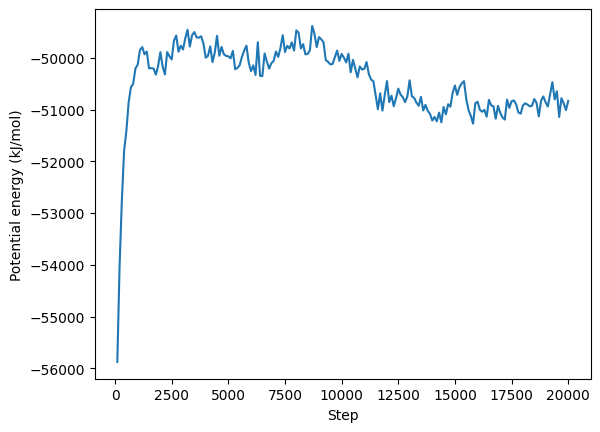

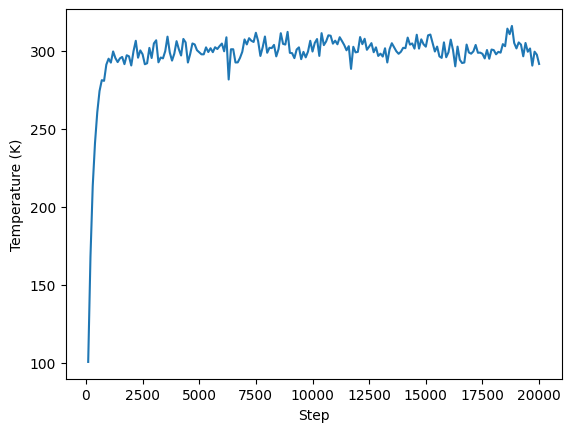

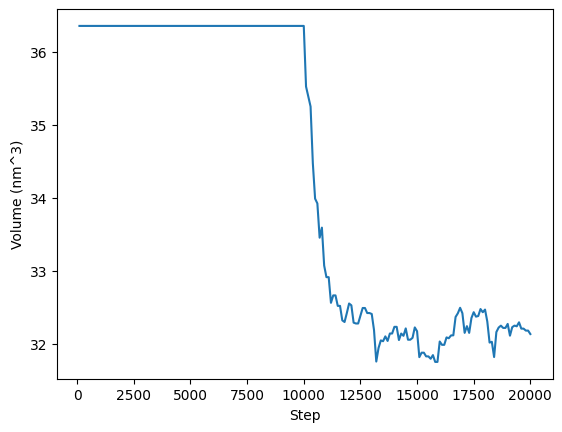

In [56]:
import numpy as np
import matplotlib.pyplot as plt
data = np.loadtxt("md_log.txt", delimiter=',')

step = data[:,0]
print(step.shape)
potential_energy = data[:,1]
temperature = data[:,2]
volume = data[:,3]y

plt.plot(step, potential_energy)
plt.xlabel("Step")
plt.ylabel("Potential energy (kJ/mol)")
plt.show()
plt.plot(step, temperature)
plt.xlabel("Step")
plt.ylabel("Temperature (K)")
plt.show()
plt.plot(step, volume)
plt.xlabel("Step")
plt.ylabel("Volume (nm^3)")
plt.show()

In [59]:
import mdtraj as md

trajectory = md.load('output_trajectory.dcd', top='output.pdb')  # Load without topology
print(f'Number of atoms in trajectory: {trajectory.n_atoms}')
print(f'Number of frames: {trajectory.n_frames}')


Number of atoms in trajectory: 3257
Number of frames: 10


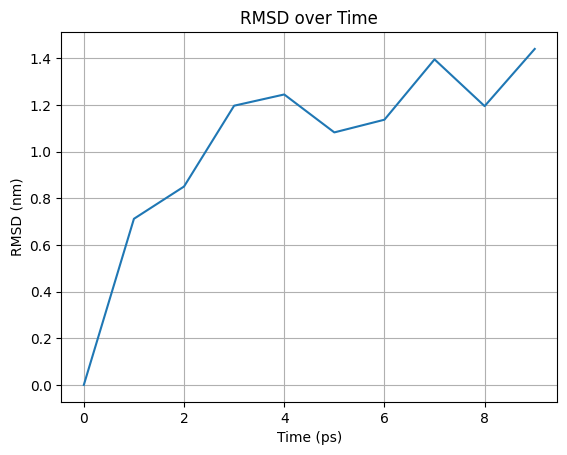

In [60]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt

# Load the trajectory and topology
trajectory = md.load('output_trajectory.dcd', top='output.pdb')  # Change to your topology file

# Choose the reference frame (often the first frame)
reference = trajectory[0]

# Calculate RMSD
rmsd = md.rmsd(trajectory, reference)

# Plot RMSD
plt.plot(trajectory.time, rmsd)
plt.xlabel('Time (ps)')
plt.ylabel('RMSD (nm)')
plt.title('RMSD over Time')
plt.grid()
plt.show()


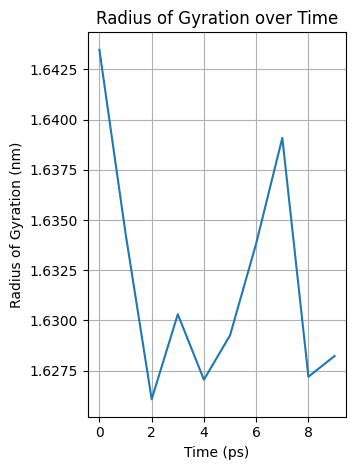

In [62]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt

# Load the trajectory and topology
trajectory = md.load('output_trajectory.dcd', top='output.pdb')  # Adjust the topology file if needed

# Choose the reference frame (often the first frame)
reference = trajectory[0]

# Calculate Radius of Gyration
radius_of_gyration = md.compute_rg(trajectory)

# Plot Radius of Gyration
plt.subplot(1, 2, 2)  # Create a subplot for Radius of Gyration
plt.plot(trajectory.time, radius_of_gyration)
plt.xlabel('Time (ps)')
plt.ylabel('Radius of Gyration (nm)')
plt.title('Radius of Gyration over Time')
plt.grid()

# Show both plots
plt.tight_layout()
plt.show()
